In [1]:
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Back, Style
sns.set()
from scipy.stats import probplot, boxcox
from scipy.special import inv_boxcox
import pylab

from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.linear_model import Ridge, Lasso, BayesianRidge,LinearRegression,ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold


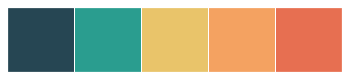

In [2]:
#Custom Color Palette 🎨
custom_colors = ["#264653","#2A9D8F","#E9C46A","#F4A261","#E76F51"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))
sns.palplot(sns.color_palette(custom_colors),size=1.2)
plt.tick_params(axis='both', labelsize=0, length = 0)

### Data 

In [3]:
train = pd.read_csv("../input/tabular-playground-series-sep-2022/train.csv")
test = pd.read_csv("../input/tabular-playground-series-sep-2022/test.csv")

In [4]:
# training 
print(f'Number of rows in training set: {Style.BRIGHT}{train.shape[0]}')
print(f'{Style.NORMAL}Number of columns in training set: {Style.BRIGHT}{train.shape[1]}')

print("\n","*"*20,"\n")
# testing
print(f'{Style.NORMAL}Number of rows in test set: {Style.BRIGHT}{test.shape[0]}')
print(f'{Style.NORMAL}Number of columns in test set: {Style.BRIGHT}{test.shape[1]}')

Number of rows in training set: 70128
Number of columns in training set: 6

 ******************** 

Number of rows in test set: 17520
Number of columns in test set: 5


In [5]:
train.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [6]:
# no column has missing values 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    70128 non-null  int64 
 1   date      70128 non-null  object
 2   country   70128 non-null  object
 3   store     70128 non-null  object
 4   product   70128 non-null  object
 5   num_sold  70128 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.2+ MB


In [7]:
print(Fore.RED + Style.BRIGHT + "Train - Earliest date:" + train["date"].min())
print(Fore.RED + Style.BRIGHT +"Train - Latest date:" + train["date"].max())

print(Fore.BLUE+ Style.BRIGHT + "Test - Earliest date:" + test["date"].min())
print(Fore.BLUE+ Style.BRIGHT + "Test - Latest date:" + test["date"].max())

Train - Earliest date:2017-01-01
Train - Latest date:2020-12-31
Test - Earliest date:2021-01-01
Test - Latest date:2021-12-31


**Note :**
1. We have our daily data of sale from **2017-01-01** to **2020-12-31** in our train set.
2. We have our daily data of sale from **2021-01-01** to **2021-12-31** in our test set.
3. There are three categorical variable country, store and product. Using them later we are going to do **univariate analysis**.
4. No missing data in any column.

### Data Preprocessing

In [8]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [9]:
def extract_info_from_date(data):
    data['Year'] = data['date'].dt.year
    data['Month'] = data['date'].dt.month
    data['Day'] = data['date'].dt.day
    data['WeekDay'] = data['date'].dt.dayofweek

    return data

train = extract_info_from_date(train)
test = extract_info_from_date(test)

### EDA

In [10]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
def product_sale(countries,filterCol,groupbyCol,data):
    n = len(countries)
    if n<3:
        col = n
        row = 1
    elif n%2==0:
        col = n//2
        row = n//col
    else:
        col = (n//2) + 1
        row = n//col
    
    colors = ["#a8e6cf","#dcedc1","#ffd3b6","#ffaaa5","#ff8b94"]
    plt.figure(figsize= (22,20))
    for idx,country in enumerate(countries):
        countryData = data[data[filterCol] == country]
        sales = countryData.groupby([groupbyCol])['num_sold'].sum().values
        product = countryData.groupby([groupbyCol])['num_sold'].sum().keys()
        explode = [0.05]*len(product)
        
        # explosion

        # Pie Chart
        plt.subplot(row,col,idx+1)
        plt.pie(sales, labels=product,colors = colors,autopct='%1.1f%%', pctdistance=0.85,explode=explode)
        # draw circle
        centre_circle = plt.Circle((0, 0), 0.50, fc='white')
        fig = plt.gcf()

        # Adding Circle in Pie chart
        fig.gca().add_artist(centre_circle)

        # Adding Title of chart
        plt.title(f'Product sales in {country} ')

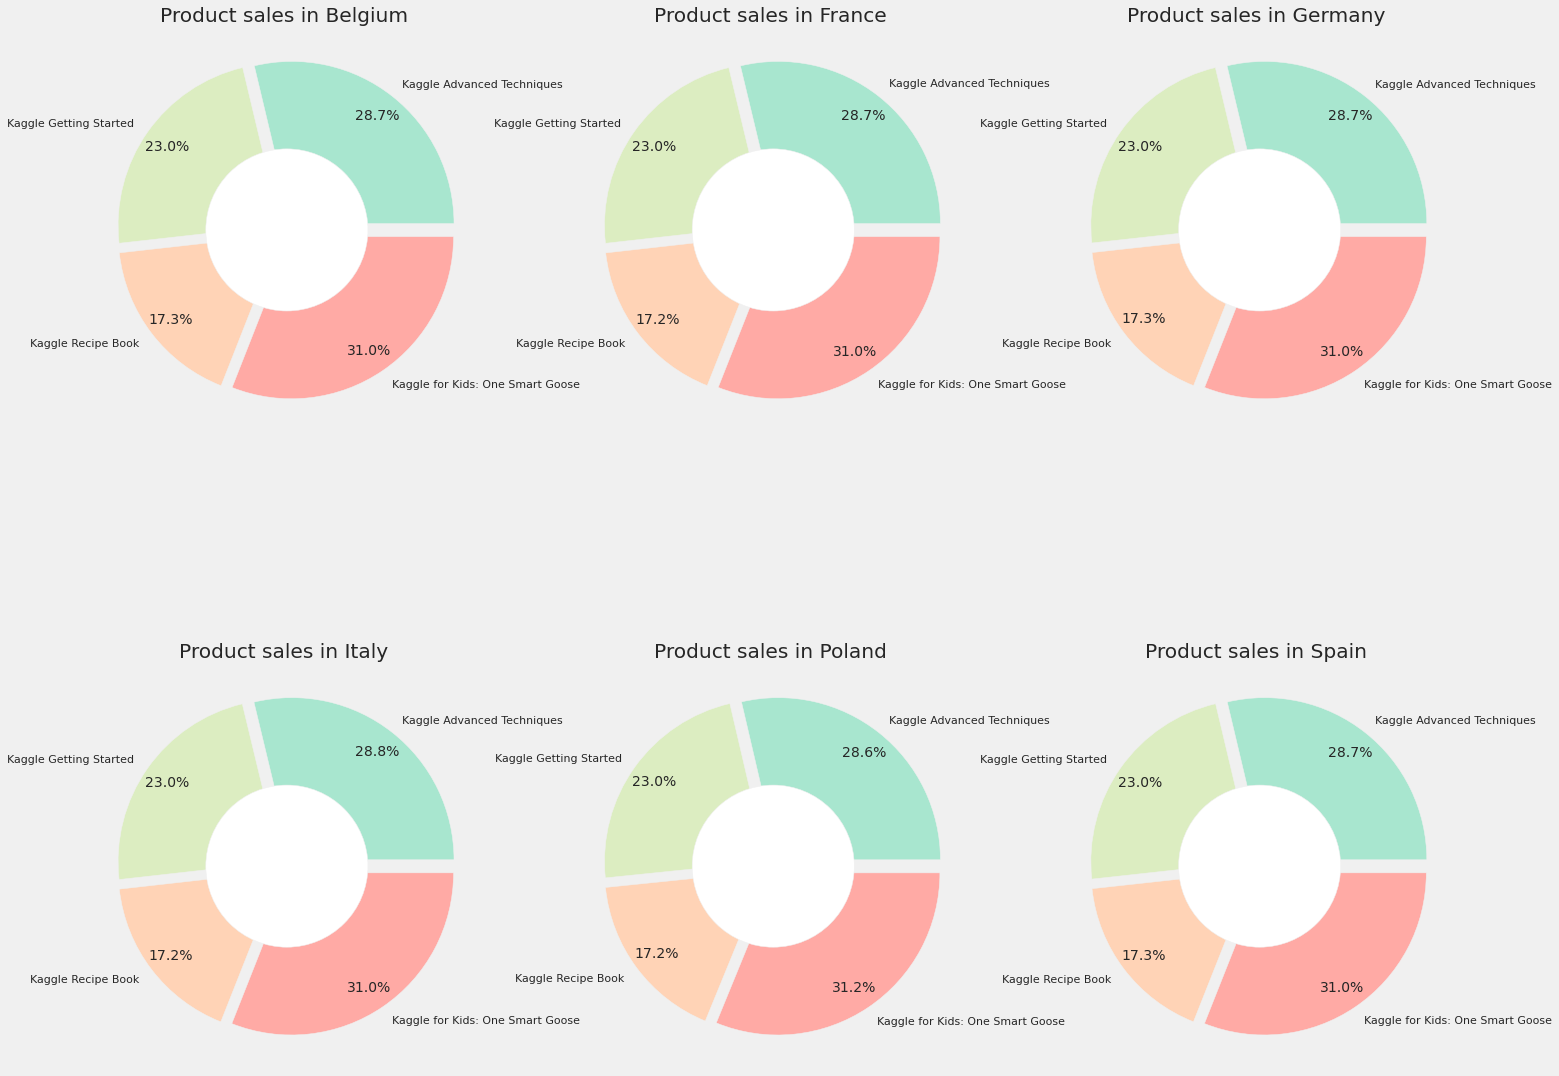

In [11]:
product_sale(train['country'].unique(),'country','product',train)

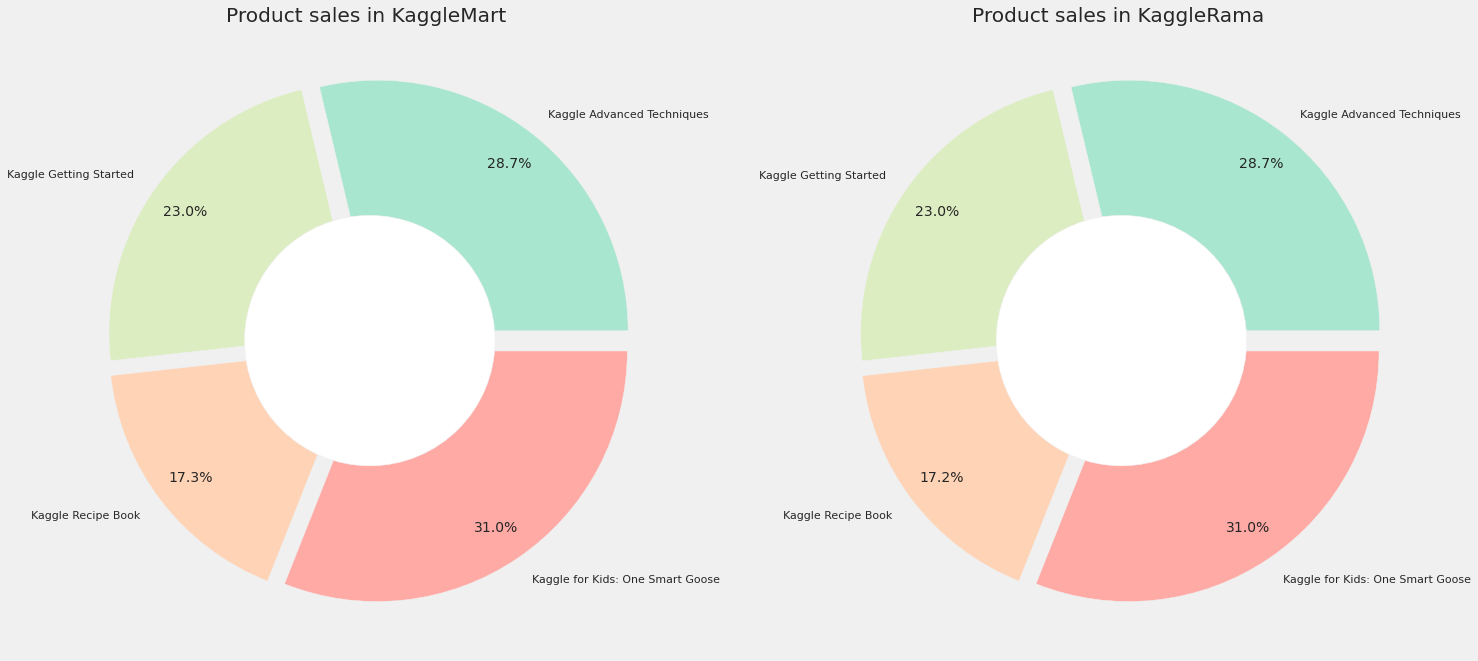

In [12]:
product_sale(train['store'].unique(),'store','product',train)

In [13]:
numSales = train.groupby(['country','product'])['num_sold'].sum().to_frame().unstack()

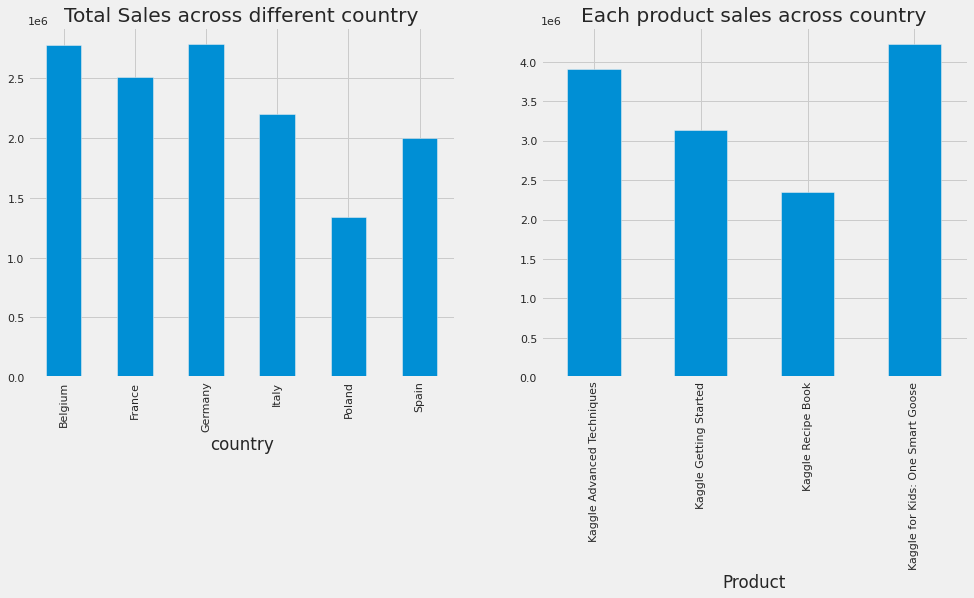

In [14]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
numSales.sum(axis=1).plot(kind='bar')
plt.title("Total Sales across different country")

plt.subplot(1,2,2)
numSales.sum().plot(kind='bar')
plt.xticks(ticks=np.arange(len(numSales.columns)),labels=list(map(lambda k: k[1],numSales.columns.tolist())))
plt.title("Each product sales across country")
plt.xlabel("Product")
plt.show()

1. Number of sales in **Germany** is highest across the countries.
2. Number of sales in **Poland** is the lowest.
3. **Kaggle for kids: One Smart Goose** has the most sales across 6 countries.
4. **Kaggle Recipe Book** has the least sales across 6 countries.

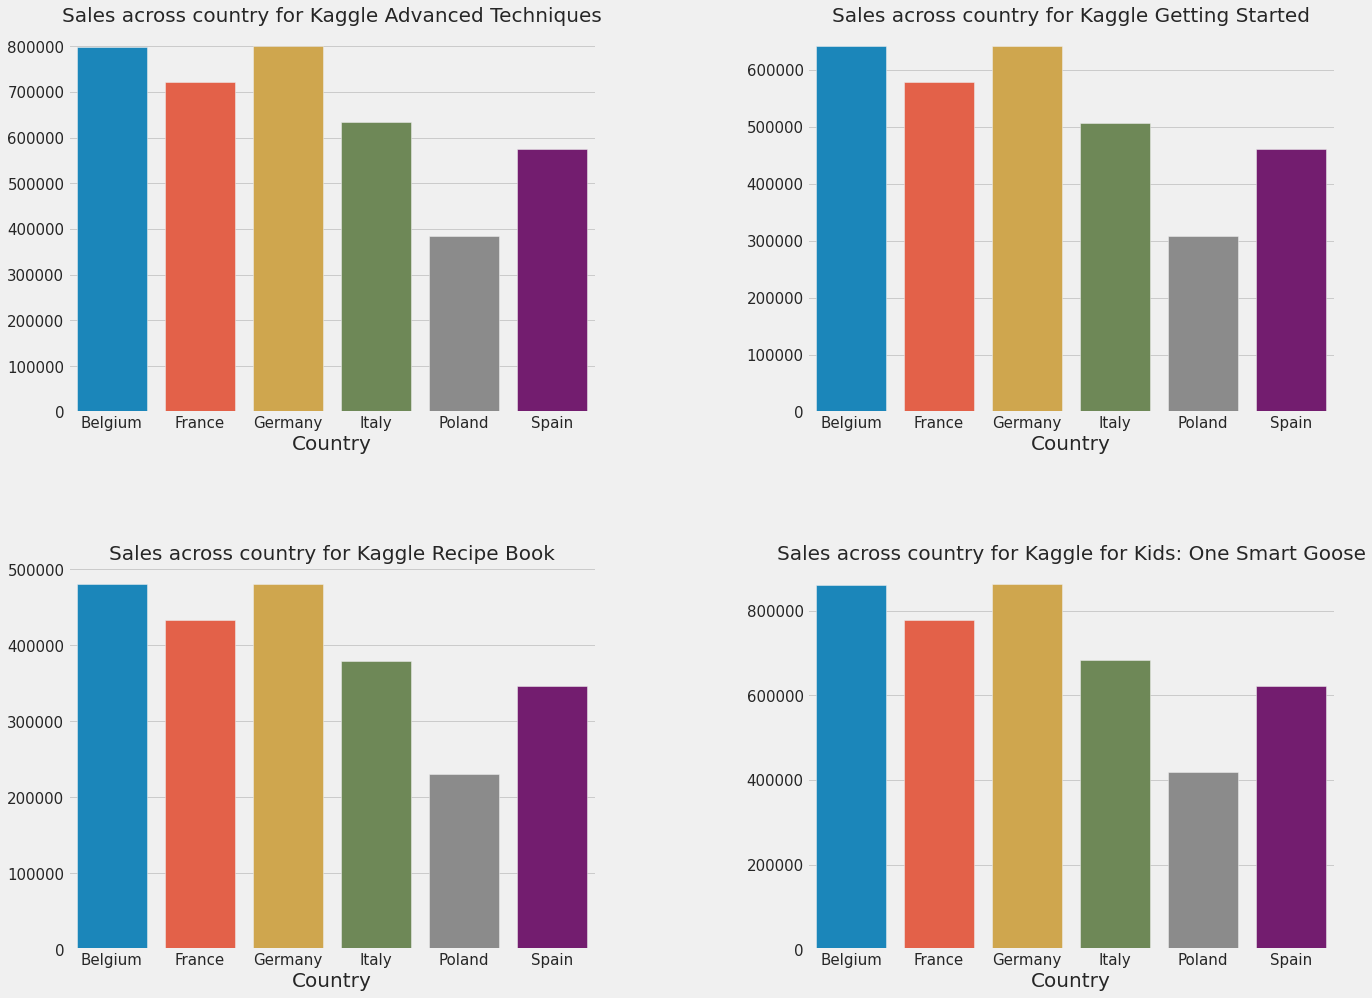

In [15]:
# sales w.r.t to each product across different country

plt.figure(figsize=(22,16))
xdata = numSales.index
for idx,col in enumerate(numSales.columns):
    n = len(numSales.columns)//2
    plt.subplot(n,n,idx+1)
    sns.barplot(x = xdata ,y=numSales[col].values)
    plt.title(f"Sales across country for {col[1]}",size=20)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.xlabel("Country",size=20)

# set the spacing between subplots
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

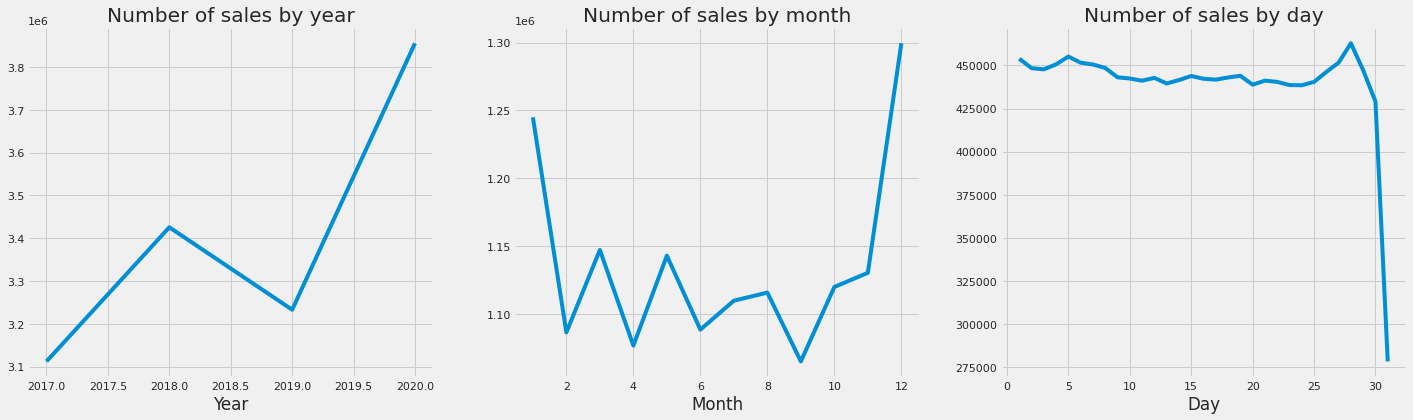

In [16]:
plt.figure(figsize=(22,6))
plt.subplot(1,3,1)
train.groupby(['Year'])['num_sold'].sum().plot(kind='line')
plt.title("Number of sales by year")
plt.subplot(1,3,2)
train.groupby(['Month'])['num_sold'].sum().plot(kind='line')
plt.title("Number of sales by month")
plt.subplot(1,3,3)
train.groupby(['Day'])['num_sold'].sum().plot(kind='line')
plt.title("Number of sales by day")
plt.show()

1. Number sales for year 2020 has great spike as compared previous year. Now, question is this spike will be seen in year 2021?
2. We can see sales were quite high during start and end of the year. But is this true for each product?
3. Number of sales were almost same across each day with a little spike towards the end and then comple fall by 30th & 31st.

#### Let's understand the behaviour of the sale across each country, store and product
1. Above we have seen the aggregated behaviour of the sales across each univariate feature.
2. Now, let's see and analyse if behaviour stays the same from each product in different store across different country.
3. If it is similar they it's safe to analyze and model them together for 2021 forecasting.

In [17]:
def plot_all(df,col):
    f,axes = plt.subplots(2,2,figsize=(20,15), sharex = True, sharey=True)
    f.tight_layout()
    for n,prod in enumerate(df["product"].unique()):
        plot_df = df.loc[df["product"] == prod]
        sns.lineplot(data=plot_df, x=col, y="num_sold", hue="country", style="store",ax=axes[n//2,n%2])
        axes[n//2,n%2].set_title("Product: "+str(prod))

In [18]:
weeklyData = train.groupby(["country","store", "product", pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()
monthlyData =  train.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()

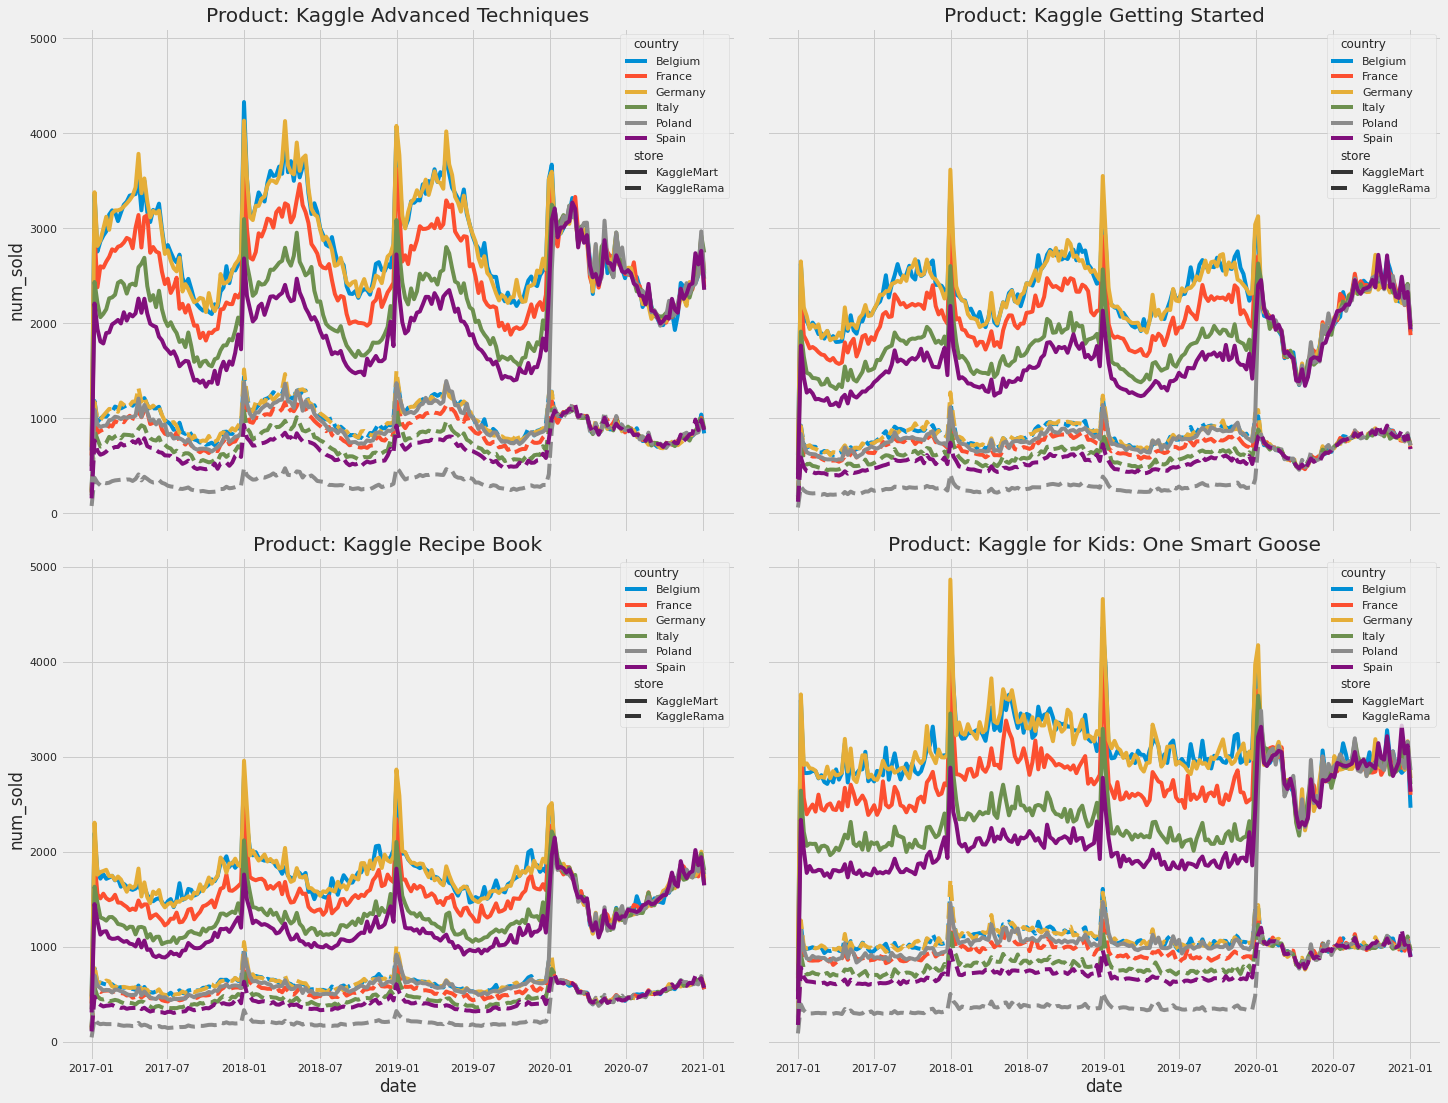

In [19]:
plot_all(weeklyData,col='date')

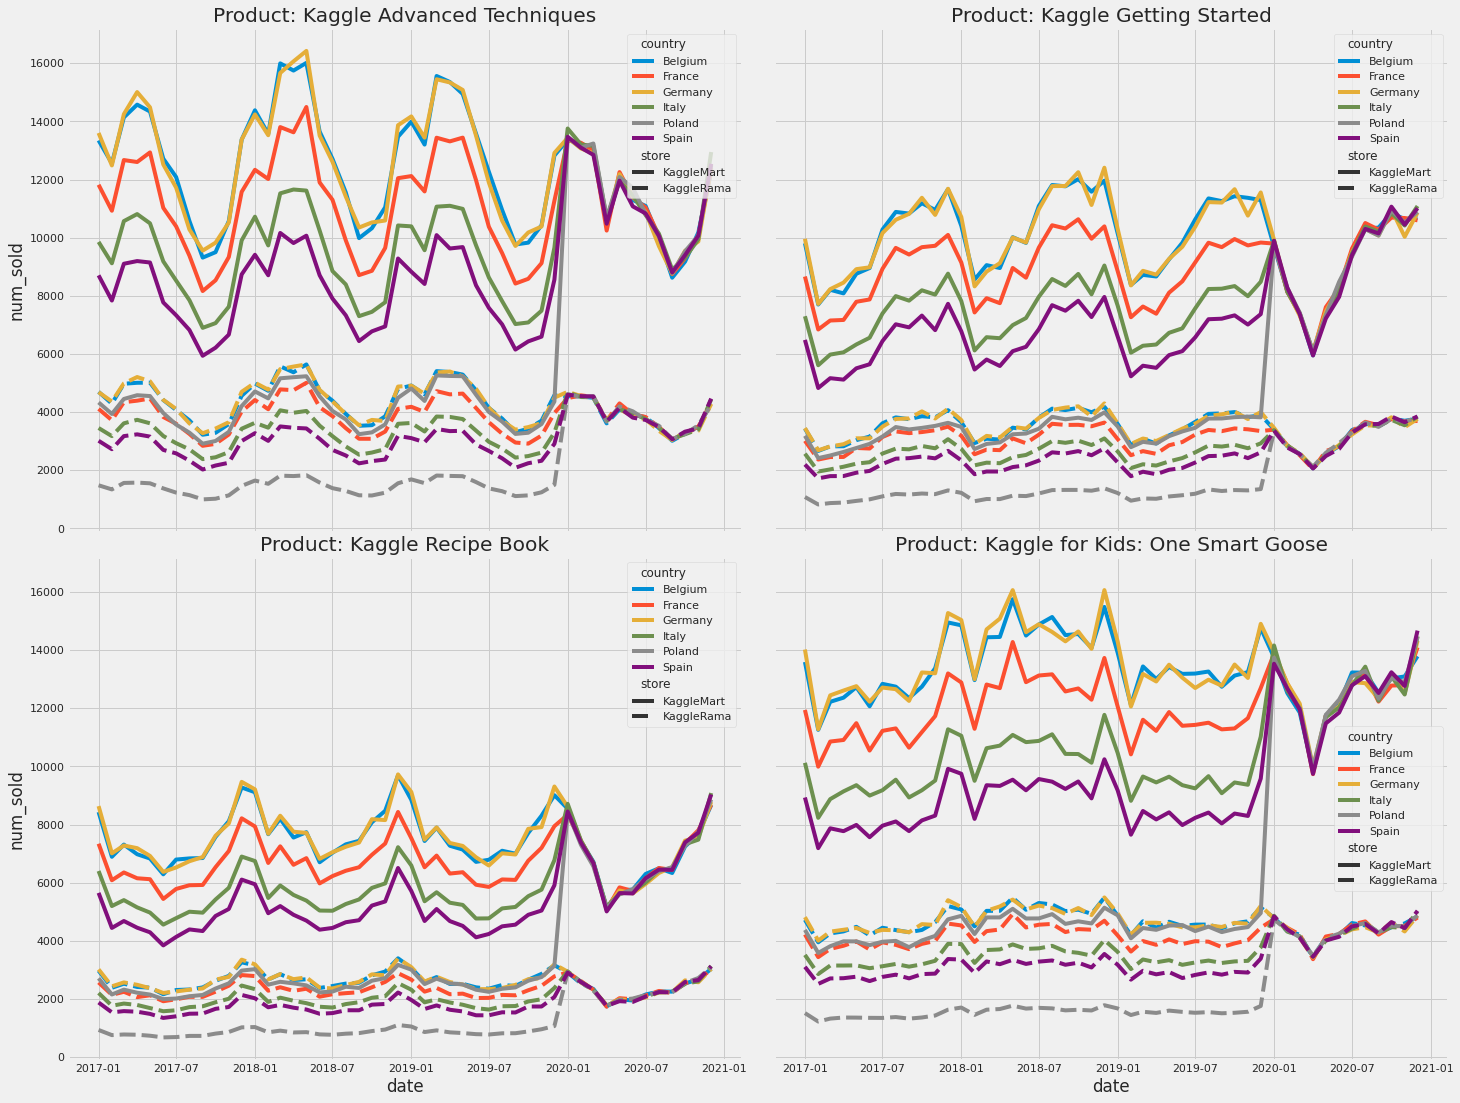

In [20]:
plot_all(monthlyData,col='date')

1. We can see there is a spike in sales on January and December month for each product.
2. We can see that each product has different pattern. But obviously with different number of sales
3. Store also have similar pattern but with different sales. In which, KagglRama has less sales.
4. And if you carefully observe pattern is similar across countries also. 
5. **Kaggle Advanced Techniques** has higher sales during the month of March to May after that there is a fall until September.
6. **Kaggle Getting Started** sales keep on increasing after April.
7. **Kaggle for kids** sales almost stays linear. There is no such downfall as compared to other products.

#### Smoothen Data for Sales every week and start of every month

In [21]:
weeklySmoothData = train.groupby(["country","store", "product",'WeekDay'])["num_sold"].sum().rename("num_sold").reset_index()
monthlySmoothData =  train.groupby(["country","store", "product", 'Month'])["num_sold"].sum().rename("num_sold").reset_index()

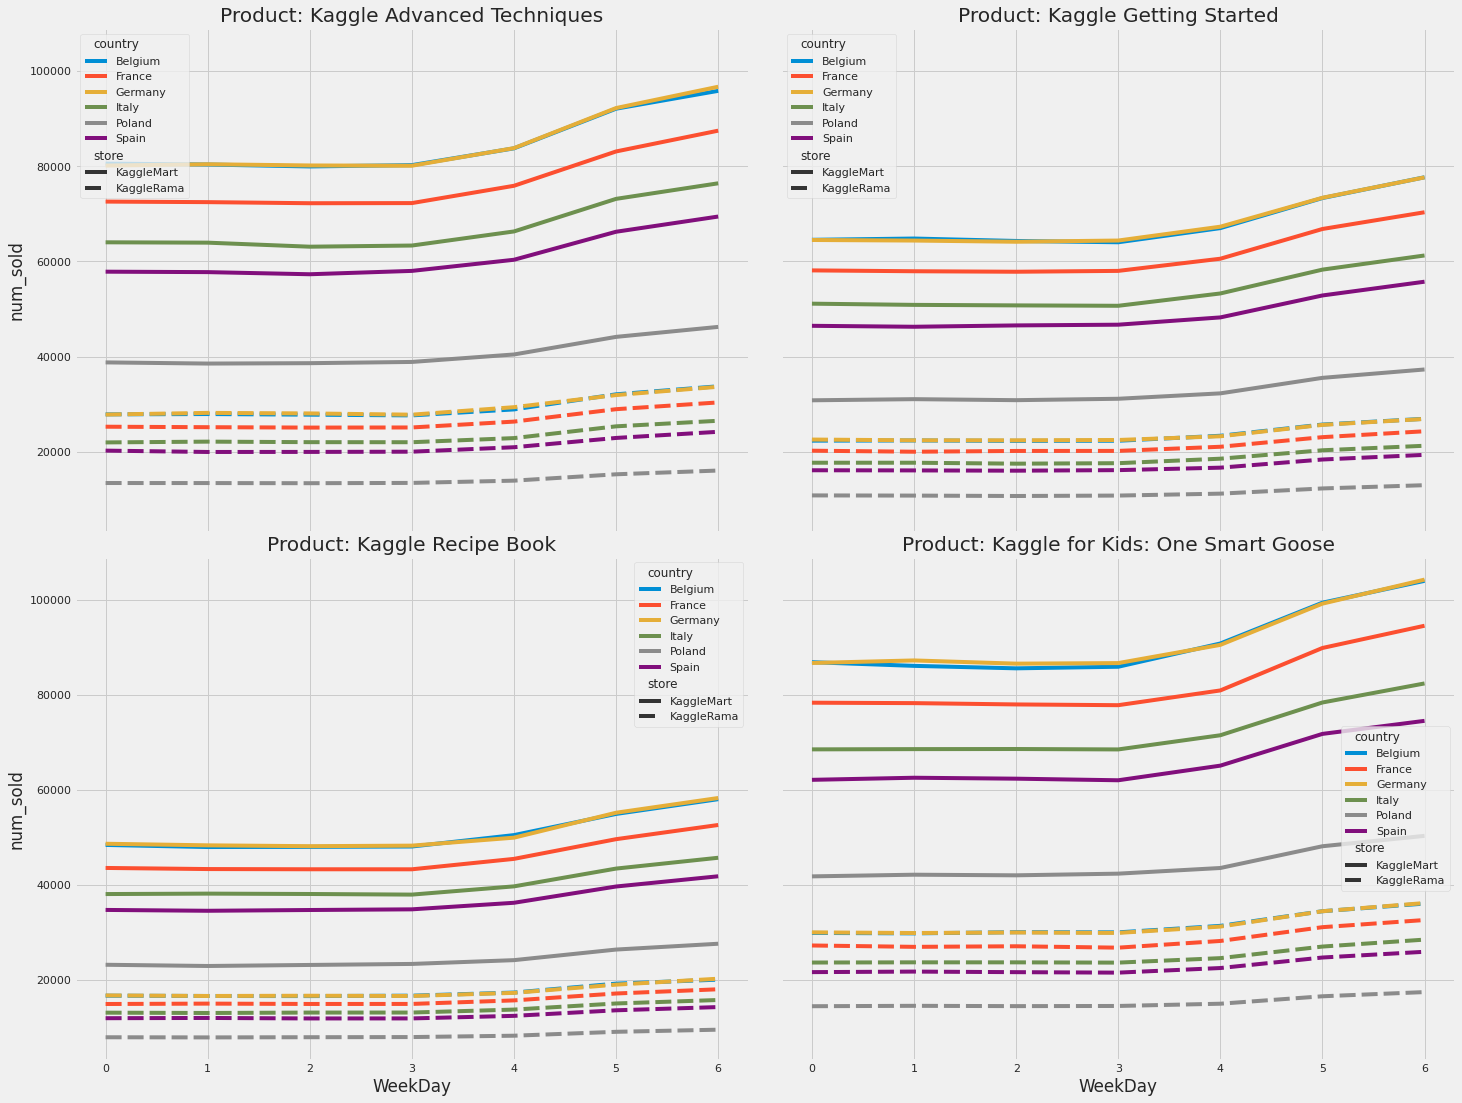

In [22]:
plot_all(weeklySmoothData,col='WeekDay')

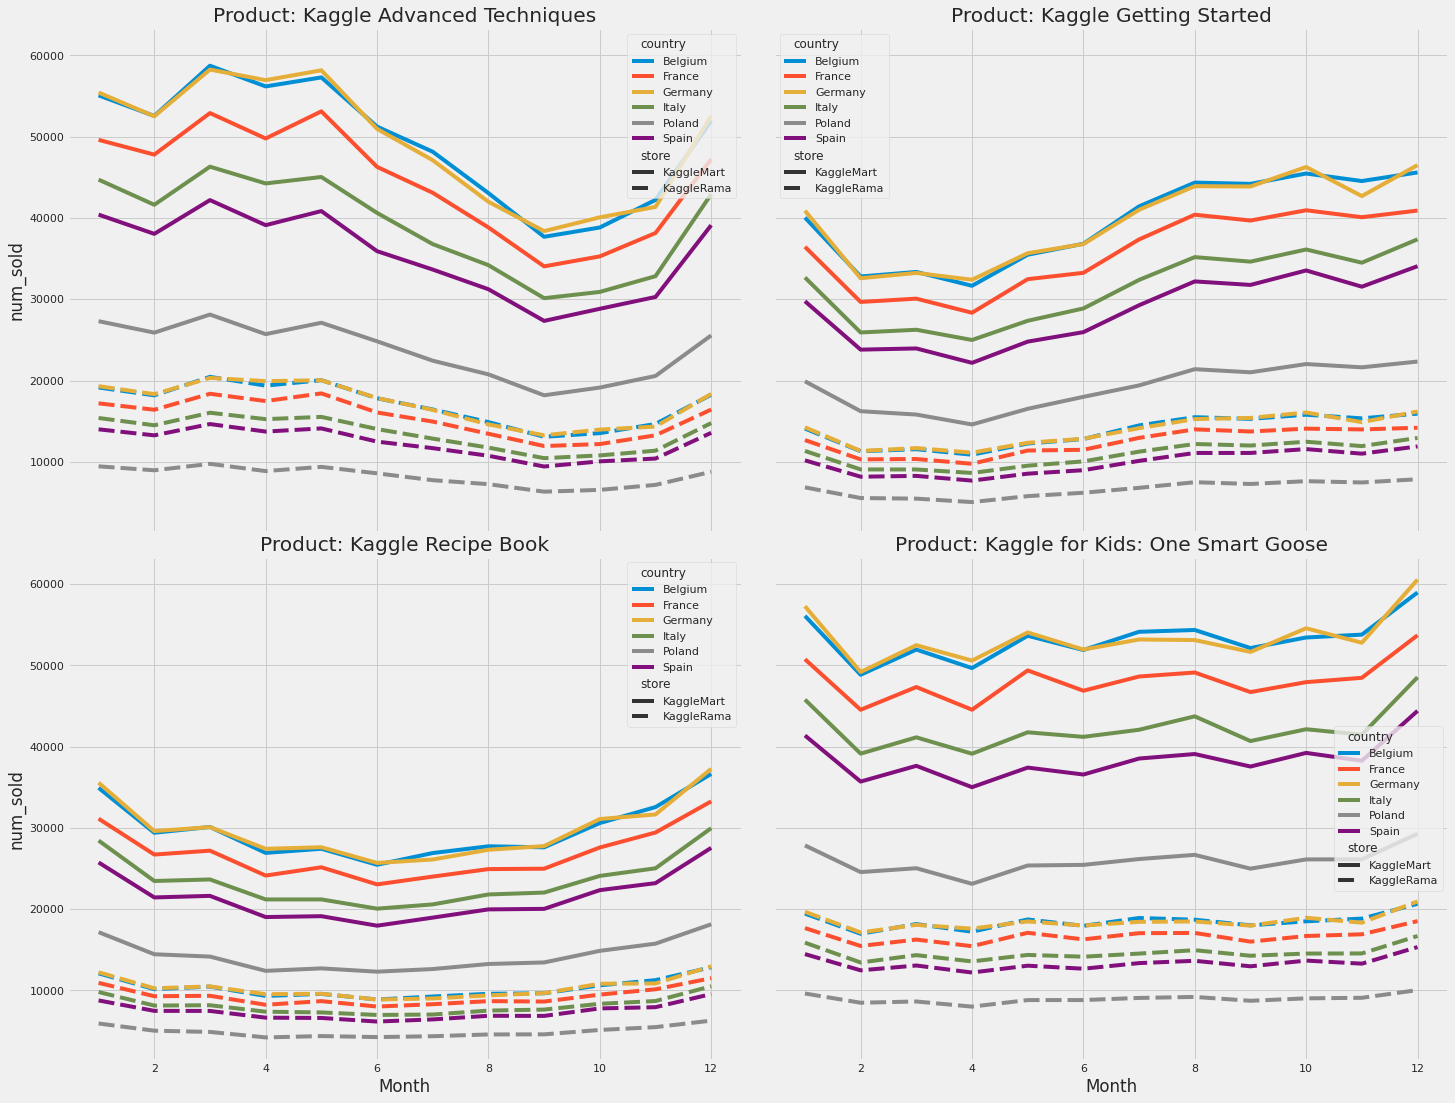

In [23]:
plot_all(monthlySmoothData,col='Month')

#### Aggregated pattern for daily data sales across each country

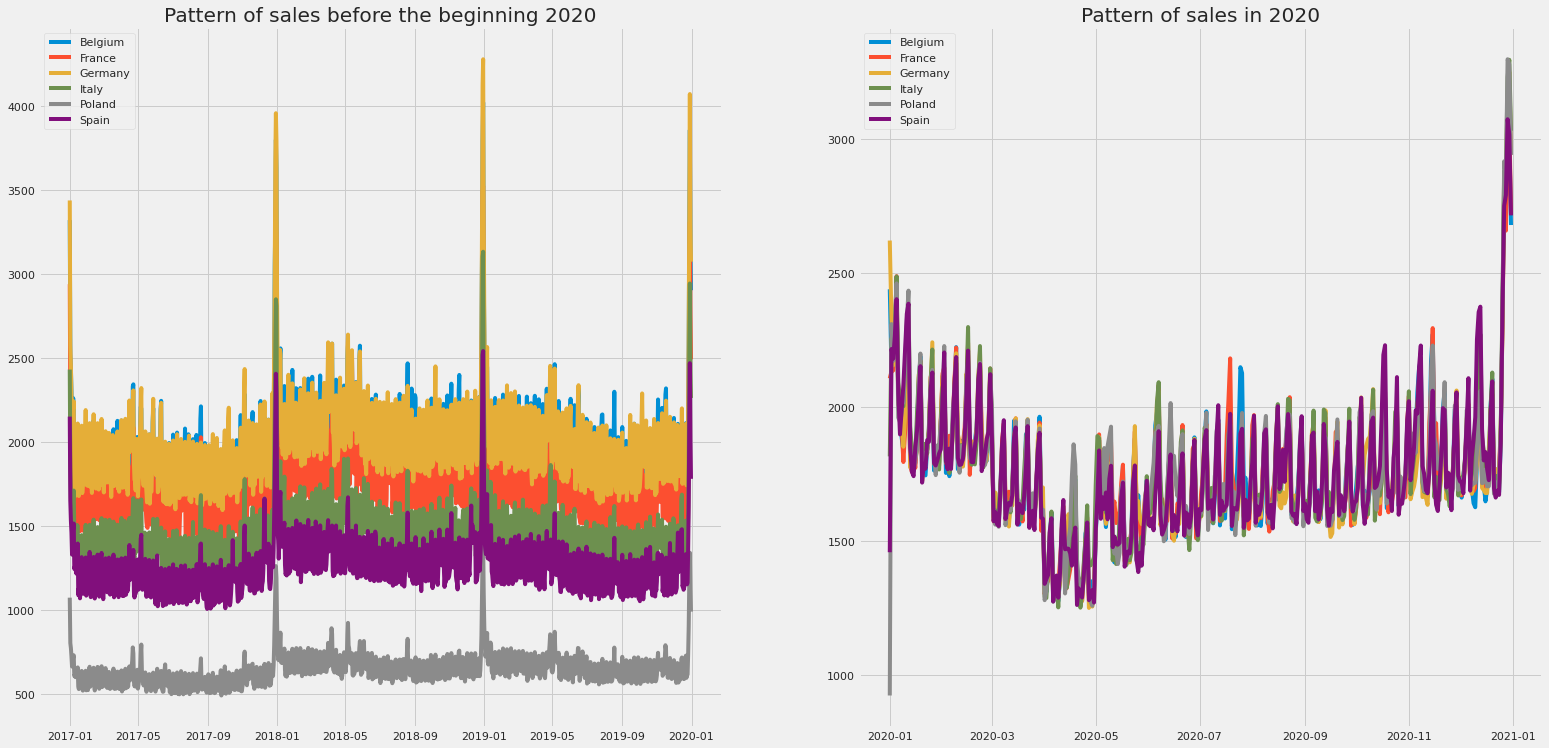

In [24]:
plt.figure(figsize=(24,12))
plt.subplot(1,2,1)
temp_df = train[train['date']<'2020-01-01']
for country in temp_df['country'].unique():
    filt_train = temp_df[temp_df['country'] == country]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=country)
    plt.title("Pattern of sales before the beginning 2020")
plt.legend()
    
temp_df = train[train['date']>='2020-01-01']
plt.subplot(1,2,2)
for country in temp_df['country'].unique():
    filt_train = temp_df[temp_df['country'] == country]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=country)
    plt.title("Pattern of sales in 2020")
    
plt.legend()
plt.show()

**Insights :** 

1. We can see the similarity in the pattern for each country prior to 2020 with just the difference in the number of sales. In **Year 2020** number of sales for each country is almost similar. As we can see in the figure(right).
2. There is definite upward trend for some sales in some countries like **Spain,Poland and Italy** but some countries like **Belgium,Germany and France** following there past pattern.
3. The difference in number of sales for different countries can be explained by single constant. Same goes for sale for different store. Although product requires different approach as mentioned in [https://www.kaggle.com/code/cabaxiom/tps-sep-22-eda-and-linear-regression-baseline#Modeling]


#### Let's zoom into the pattern for each country seperately

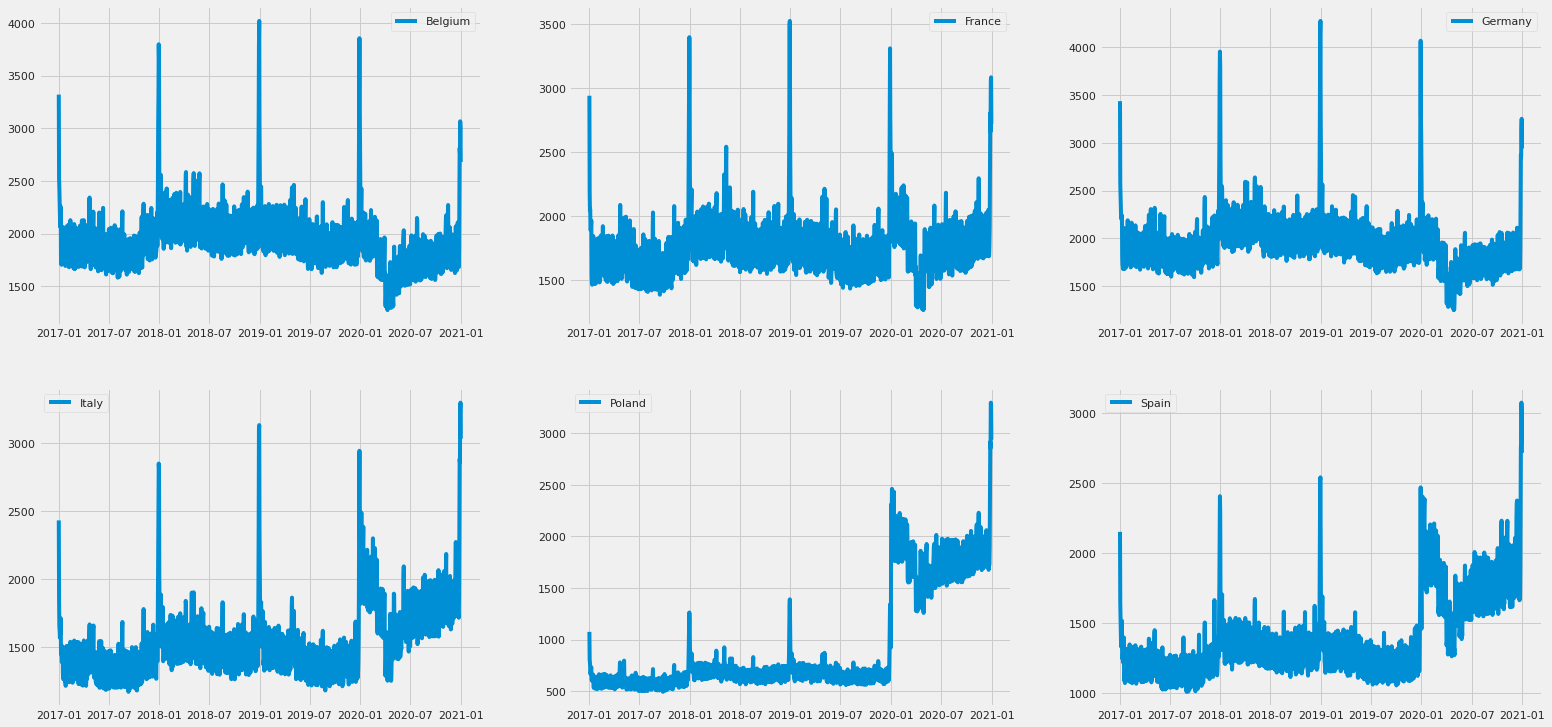

In [25]:
plt.figure(figsize=(24,12))
for idx,country in enumerate(train['country'].unique()):
    filt_train = train[train['country'] == country]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.subplot(2,3,idx+1) 
    plt.plot(train_gp['date'], train_gp['num_sold'], label=country)
    plt.legend()
plt.show()

**Observations** :
1. As mentioned earlier countries like **Belgium, France & Germany** follow similar pattern as past. Just ignore the time between **2020-01 to 2020-06** within this period there is a fall in number of sales for each product. 
2. So, during the training we are going to ignore the date from the period **2020-03 to 2020-06**.

### Modelling

**Note**

There is some things to consider before we move on to modelling section :<br>
    1. From the year 2020 the number of sales for each product from all countries has becomes equal. Significantly increasing the sale for some countries.<br>
    2. The impact of covid can be seen around the date **March 2020 to May 2020**.<br>
    3. So, we are going to consider the first part will remain same during the year 2021 and to cancel out the impact of covid on the sales we are going to ignore the date for that specific time period.

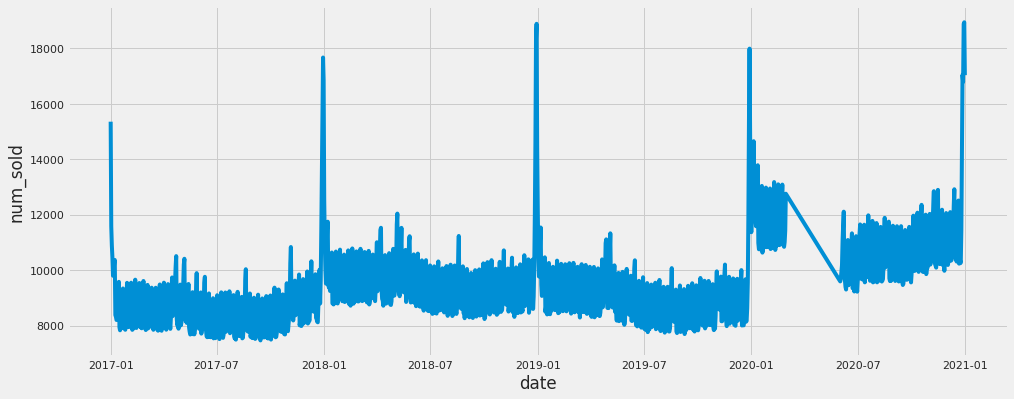

In [26]:
temp = train.loc[~((train["date"] >= "2020-03-01") & (train["date"] < "2020-06-01"))] # remove data from march 2020 to may 2020
train_agg = temp.groupby(["date"])["num_sold"].sum().reset_index()
f,ax = plt.subplots(figsize=(15,6))
sns.lineplot(data = train_agg, x="date", y="num_sold")

test_agg = test.groupby(["date"])["row_id"].first().reset_index().drop(columns="row_id")
test_dates = test_agg[["date"]]

In [27]:
def get_holidays(df):
    years_list = [2017, 2018, 2019, 2020, 2021]

    holiday_BE = holidays.CountryHoliday('BE', years = years_list)
    holiday_FR = holidays.CountryHoliday('FR', years = years_list)
    holiday_DE = holidays.CountryHoliday('DE', years = years_list)
    holiday_IT = holidays.CountryHoliday('IT', years = years_list)
    holiday_PL = holidays.CountryHoliday('PL', years = years_list)
    holiday_ES = holidays.CountryHoliday('ES', years = years_list)

    holiday_dict = holiday_BE.copy()
    holiday_dict.update(holiday_FR)
    holiday_dict.update(holiday_DE)
    holiday_dict.update(holiday_IT)
    holiday_dict.update(holiday_PL)
    holiday_dict.update(holiday_ES)

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    
    return df

def encode_holiday_names(df, enc, subset='train'):
    if subset=='train':
        df['holiday_name'] = enc.fit_transform(df['holiday_name'].values.reshape(-1,1))
    else:
        df['holiday_name'] = enc.transform(df['holiday_name'].values.reshape(-1,1))
        not_hol_val = oe.transform([['Not Holiday']])[0,0]
        df.loc[df['holiday_name']==-1, 'holiday_name'] = not_hol_val
    return df

In [28]:
import dateutil.easter as easter

def feature_engineer(df):
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
    new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    new_df["day"] = df["date"].dt.day
    new_df["day_sin"] = np.sin(new_df['day'] * (2 * np.pi / 12))
    new_df["day_of_week"] = df["date"].dt.dayofweek
    new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    
    new_df["day_of_year"] = df["date"].dt.dayofyear
    #account for leap year
    new_df["day_of_year"] = new_df.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)
    new_df["important_dates"] = new_df["day_of_year"].apply(lambda x: x if x in [1,2,3,4,5,6,7,8,125,126,360,361,362,363,364,365] else 0)
    
    new_df["year"] = df["date"].dt.year
    
    easter_date = new_df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    for day in list(range(-5, 5)) + list(range(40, 48)):
        new_df[f'easter_{day}'] = (new_df.date - easter_date).dt.days.eq(day)
    new_df = new_df.drop(columns=["date","month","day", "day_of_year"])
    
    for col in new_df.columns :
        if 'easter' in col :
            new_df = pd.get_dummies(new_df, columns = [col], drop_first=True)
    
    new_df = pd.get_dummies(new_df, columns = ["important_dates","day_of_week"], drop_first=True)
    
    return new_df

In [29]:
# feature engineering
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train_agg = get_holidays(train_agg)
test_agg = get_holidays(test_agg)

train_pred = pd.DataFrame()
train_pred['date'] = train_agg['date']

y_train = train_agg["num_sold"]
X_train = train_agg.drop(columns="num_sold")
X_test = test_agg

X_train = feature_engineer(X_train)
X_test = feature_engineer(X_test)

X_train = encode_holiday_names(X_train, oe)
X_test = encode_holiday_names(X_test, oe)

In [30]:
preds_lst = []
# n_splits=4 is because we grouping over the year and in our train data we have 2017-2020 year data
kf = GroupKFold(n_splits=4)
scores = []
train_scores = [0]*len(X_train)
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, groups=X_train.year)):
    model = Lasso(tol=0.000001,max_iter=100000,alpha=0.03,random_state=42)
#     model = LinearRegression()
    scale = StandardScaler()
    X_train = pd.DataFrame(scale.fit_transform(X_train,y_train),columns=X_train.columns)
    X_test = pd.DataFrame(scale.transform(X_test),columns=X_test.columns)
    model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    preds_lst.append(model.predict(X_test))
    train_scores+= model.predict(X_train)/4
    sc =  model.score(X_train.iloc[val_idx], y_train.iloc[val_idx])
    scores.append(sc)
    print(fold, sc)
train_pred['num_sold'] = train_scores
print("Mean score", np.mean(scores))

0 -0.5325119401143503
1 0.7390109112651823
2 0.8577203446935919
3 -0.5792189980004874
Mean score 0.12125007946098415


In [31]:
preds_df = pd.DataFrame(np.column_stack(preds_lst), columns = ["2017", "2018", "2019", "2020"])
#average predictions from kfold
preds_df['num_sold'] = preds_df.sum(axis = 1)/len(preds_lst)
test_dates["num_sold"] = preds_df['num_sold']

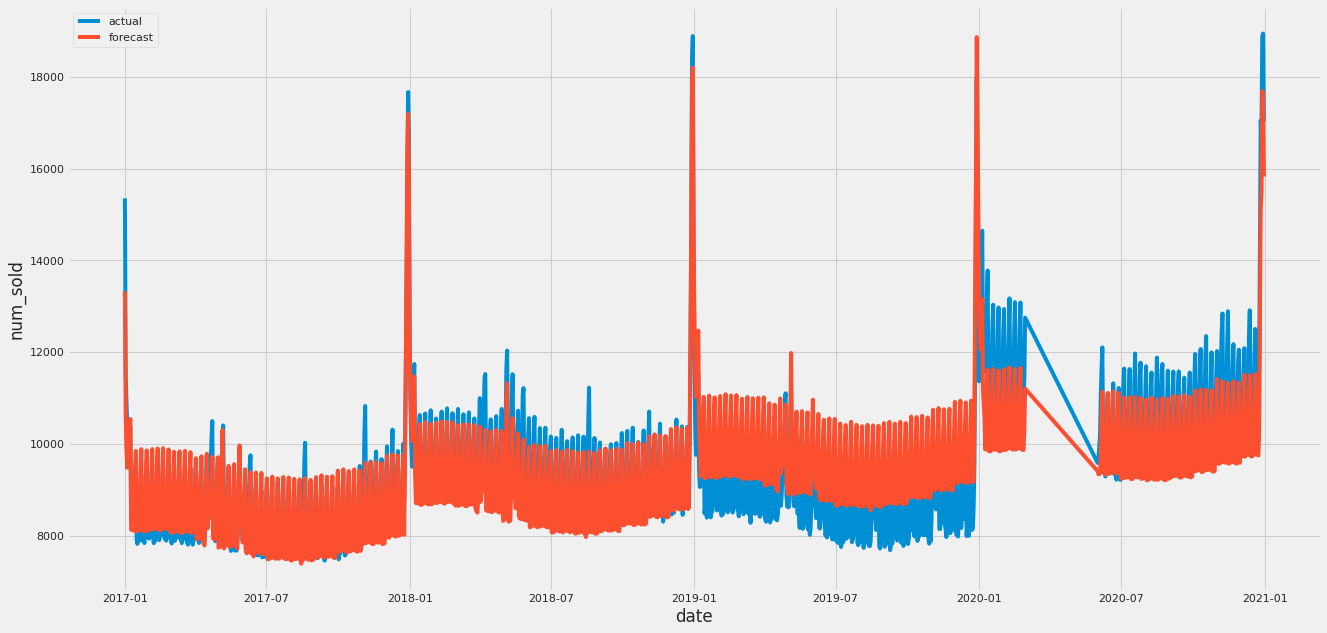

In [32]:
plt.figure(figsize=(20,10))
sns.lineplot(data = train_agg, x="date", y="num_sold",label = 'actual')
sns.lineplot(data = train_pred,x='date',y='num_sold',label = "forecast")
plt.show()

1. As compare to year **2017,2018**, the year 2019, our forecast value is significantly different from the actual.
2. We can still improve around this area.

#### Year 2021 forecasting based on trained model

<AxesSubplot:xlabel='date', ylabel='num_sold'>

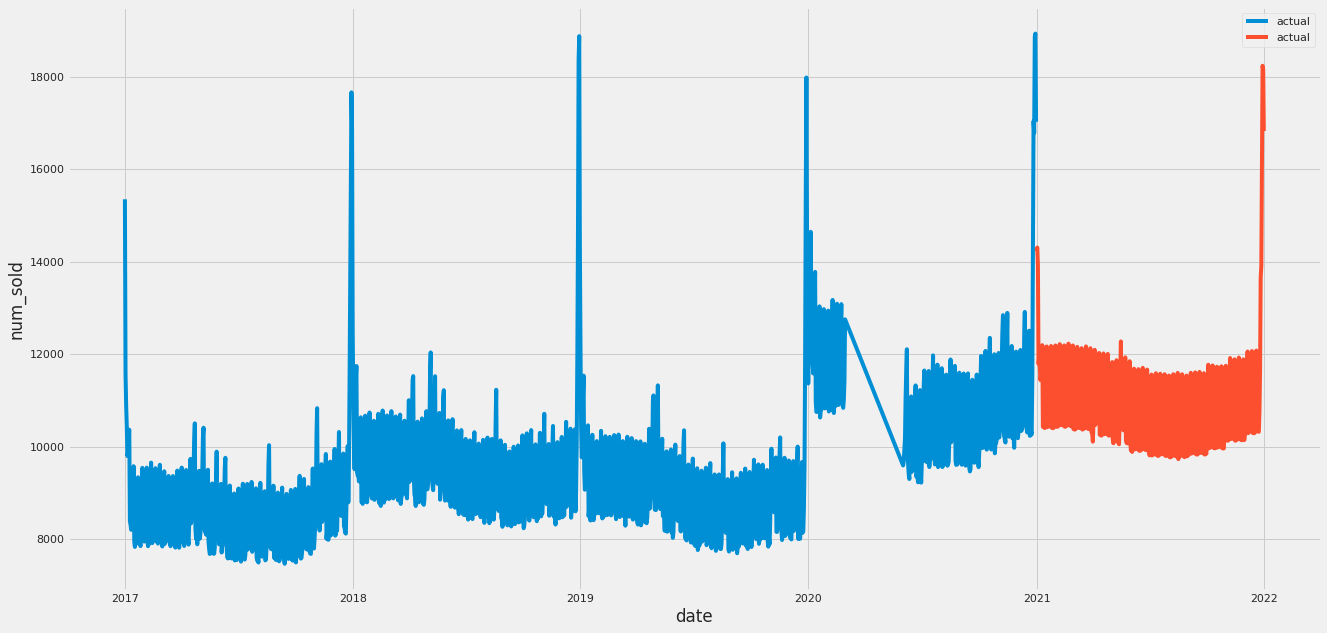

In [33]:
plt.figure(figsize=(20,10))
sns.lineplot(data = train_agg, x="date", y="num_sold",label = 'actual')
sns.lineplot(data = test_dates, x="date", y="num_sold",label = 'actual')

In [34]:
product_df = train.groupby(["date","product"])["num_sold"].sum().reset_index()
product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("ratios").reset_index()
product_ratio_df.head()

,date,product,ratios
0,2017-01-01,Kaggle Advanced Techniques,0.277944
1,2017-01-01,Kaggle Getting Started,0.227462
2,2017-01-01,Kaggle Recipe Book,0.188900
3,2017-01-01,Kaggle for Kids: One Smart Goose,0.305693
4,2017-01-02,Kaggle Advanced Techniques,0.280014


In [35]:
# mean_ratios = [0]*1460
mean_ratios = []
for year in train['Year'].unique()[:-1]:
    product_ratio_2019 = product_ratio_df.loc[product_ratio_df["date"].dt.year == year].copy()
    product_ratio_2019["mm-dd"] = product_ratio_2019["date"].dt.strftime('%m-%d')
    product_ratio_2019 = product_ratio_2019.drop(columns="date")
    product_ratio_2019 = product_ratio_2019.reset_index()
#     mean_ratios+=product_ratio_2019['ratios']
    mean_ratios.append(product_ratio_2019['ratios'])
    
product_ratio_test = test.copy()

product_ratio_2019['mean_ratios'] = (mean_ratios[0]*0.4+mean_ratios[1]*0.1+mean_ratios[2]*0.5)

product_ratio_test["mm-dd"] = product_ratio_test["date"].dt.strftime('%m-%d')

product_ratio_test = pd.merge(product_ratio_test,product_ratio_2019, how="left", on = ["mm-dd","product"])
product_ratio_test.head()

,row_id,date,country,store,product,Year,Month,Day,WeekDay,mm-dd,index,ratios,mean_ratios
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,2021,1,1,4,01-01,2920,0.279273,0.278866
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,2021,1,1,4,01-01,2921,0.230832,0.228888
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,2021,1,1,4,01-01,2922,0.188119,0.188658
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,2021,1,1,4,01-01,2923,0.301776,0.303587
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,2021,1,1,4,01-01,2920,0.279273,0.278866


<AxesSubplot:xlabel='date', ylabel='ratios'>

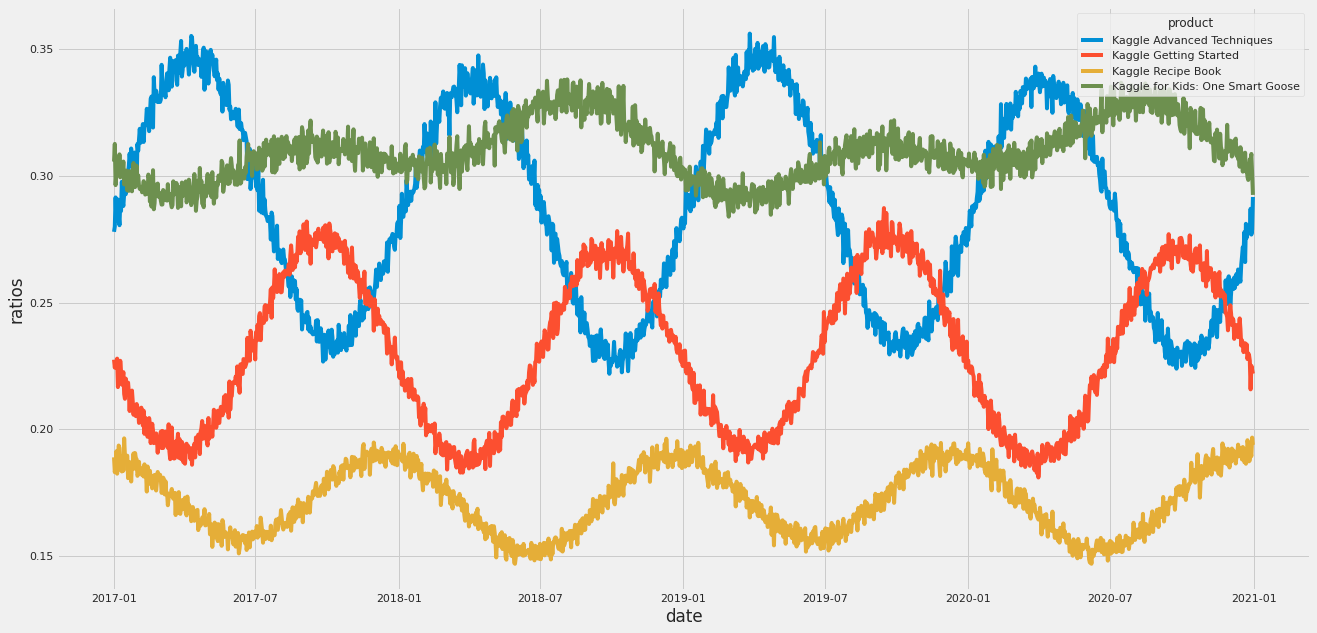

In [36]:
temp_df = pd.concat([product_ratio_df,test_agg]).reset_index(drop=True)
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=temp_df, x="date", y="ratios", hue="product")

In [37]:
def disaggregate_forecast(df,original_data):
    new_df = df.copy()
    
    stores_weights = original_data.groupby("store")["num_sold"].sum()/original_data["num_sold"].sum()
    country_weights = pd.Series(index = df["country"].unique(),data = 1/6)

    for country in country_weights.index:
        new_df.loc[(new_df["country"] == country), "num_sold"] = new_df.loc[(new_df["country"] == country), "num_sold"] *  country_weights[country]
        
    for store in store_weights.index:
        new_df.loc[new_df["store"] == store, "num_sold"] = new_df.loc[new_df["store"] == store, "num_sold"] * store_weights[store]
    
    #apply product weights (which is dependent on date)
    new_df["num_sold"] = new_df["num_sold"] * new_df["ratios"]
    new_df["num_sold"] = new_df["num_sold"].round()
    new_df = new_df.drop(columns=["ratios"])
    
    return new_df

In [38]:
test_data = pd.merge(test, test_dates, how="left")
test_data["ratios"] = product_ratio_test["mean_ratios"]
test_data.head()

,row_id,date,country,store,product,Year,Month,Day,WeekDay,num_sold,ratios
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,2021,1,1,4,14238.829389,0.278866
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,2021,1,1,4,14238.829389,0.228888
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,2021,1,1,4,14238.829389,0.188658
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,2021,1,1,4,14238.829389,0.303587
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,2021,1,1,4,14238.829389,0.278866


In [39]:
store_weights = train.groupby("store")["num_sold"].sum()/train["num_sold"].sum()
country_weights = train.loc[train["date"] < "2020-01-01"].groupby("country")["num_sold"].sum()/train.loc[train["date"] < "2020-01-01", "num_sold"].sum()

In [40]:
final_df = disaggregate_forecast(test_data,train)
final_df

,row_id,date,country,store,product,Year,Month,Day,WeekDay,num_sold
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,2021,1,1,4,491.0
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,2021,1,1,4,403.0
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,2021,1,1,4,332.0
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,2021,1,1,4,535.0
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,2021,1,1,4,170.0
...,...,...,...,...,...,...,...,...,...,...
17515,87643,2021-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,2021,12,31,4,635.0
17516,87644,2021-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,2021,12,31,4,202.0
17517,87645,2021-12-31,Spain,KaggleRama,Kaggle Getting Started,2021,12,31,4,162.0
17518,87646,2021-12-31,Spain,KaggleRama,Kaggle Recipe Book,2021,12,31,4,138.0


In [41]:
submission = pd.read_csv("../input/tabular-playground-series-sep-2022/sample_submission.csv")
submission["num_sold"] = final_df["num_sold"]

submission.to_csv('submission.csv', index = False)